# ALBERT for Fake News Detection

## 1. Introduction

This notebook demonstrates how to finetune ALBERT (A Lite BERT) for detecting fake news using the WELFake dataset. ALBERT is an efficient transformer model that introduces several key architectural innovations to reduce model size while maintaining or even improving performance compared to BERT.

ALBERT achieves dramatic parameter reduction through two main techniques:
1. **Factorized embedding parameterization**: Separates the size of the hidden layers from the size of vocabulary embeddings
2. **Cross-layer parameter sharing**: Reuses parameters across transformer layers

These innovations allow ALBERT-base to have only about 12 million parameters, compared to BERT-base's 110 million, while achieving comparable or better performance on many natural language understanding benchmarks. This efficiency makes it an excellent candidate for fake news detection applications where both accuracy and computational efficiency are important.

### Why ALBERT for Fake News Detection?

Transformer models have become the standard for NLP tasks due to their ability to capture contextual relationships in text. However, the large size of models like BERT makes deployment challenging in many scenarios. ALBERT addresses these limitations through parameter-efficient architecture design.

For fake news detection, ALBERT offers several advantages:
- High accuracy through contextual understanding of language
- Much smaller model size for easier deployment
- Efficient inference for faster processing of news articles
- Potential for better generalization through its self-supervised learning approach

## 2. Environment Setup

First, let's import the necessary libraries and set up our environment. We'll need PyTorch for deep learning, Hugging Face Transformers for the model, and various utilities for data processing and evaluation.

In [1]:
# Import basic utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### PyTorch and System Libraries
We import PyTorch for our deep learning framework and set up system utilities for file management and timing.

In [2]:
# Import PyTorch
import torch
import os
import time
import random

### Hugging Face Libraries
The Transformers library provides pre-trained models and utilities for fine-tuning, while the Datasets library helps with efficient data handling.

In [3]:
# Import Hugging Face libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset

2025-05-19 14:40:46.326099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747665646.562461      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747665646.628383      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Evaluation Libraries
These libraries will help us measure our model's performance with standard metrics.

In [4]:
# Import evaluation libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

### Utilities for Clean Output
We'll suppress warnings to keep our notebook clean and focused on the results.

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Setting Up Reproducibility
Setting a random seed ensures our results are reproducible across different runs.

In [6]:
# Set seeds for reproducibility
def set_seed(seed_value=42):
    """
    Set seeds for all random number generators to ensure reproducibility.
    This affects random, numpy, PyTorch CPU and GPU operations.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True

In [7]:
# Apply seed
set_seed()

### Checking Hardware Availability
We'll check if a GPU is available to accelerate training.

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Loading and Exploring the Dataset

The WELFake dataset combines real and fake news articles from multiple sources. Let's load it and understand its structure and distribution before proceeding with model training.

In [9]:
# Load the cleaned dataset
df = pd.read_csv('/kaggle/input/welfake-cleaned/WELFake_cleaned.csv')

### Dataset Size and Shape
First, let's check the overall size of the dataset to understand how much data we're working with.

In [10]:
# Display basic information
print(f"Dataset shape: {df.shape}")

Dataset shape: (71537, 10)


### Class Distribution
It's important to check the balance between real and fake news articles to ensure our model doesn't develop bias toward the majority class.

In [11]:
# Check class distribution
class_distribution = df['label'].value_counts(normalize=True).mul(100).round(2)
print(f"Class distribution:")
print(class_distribution)

Class distribution:
label
1    51.04
0    48.96
Name: proportion, dtype: float64


### Visualizing the Class Distribution
A visual representation helps us better understand the dataset balance.

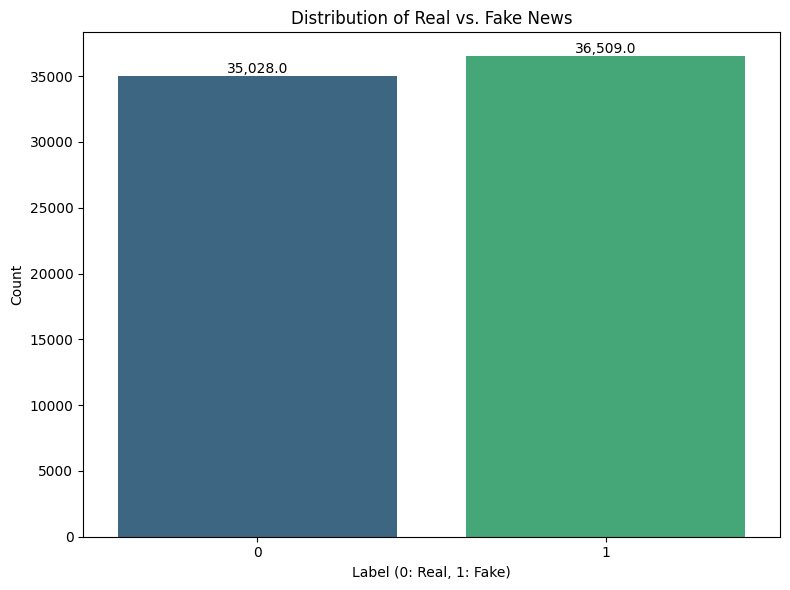

In [12]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.tight_layout()
plt.show()

### Sample Data
Examining a few samples helps us understand the content and structure of the articles.

In [13]:
# Display sample data
print("\nSample data:")
print(df.head(3))


Sample data:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
2           3  Bobby Jindal, raised Hindu, uses story of Chri...   

                                                text  label  title_length  \
0  No comment is expected from Barack Obama Membe...      1           130   
1   Now, most of the demonstrators gathered last ...      1           137   
2  A dozen politically active pastors came here f...      0           105   

   text_length  word_count  title_has_allcaps  title_exclamation  \
0         5049         871               True              False   
1          216          34               True               True   
2         8010        1321              False              False   

   title_question  
0           False  
1           False  
2           False  


## 4. Data Preprocessing

For transformer-based models like ALBERT, we need to carefully prepare our input data. We'll combine the article title and text to provide complete information to the model and then split our data into training, validation, and test sets.

### Combining Title and Text
For news articles, both the headline and body contain important information. By combining them, we provide the model with the complete content.

In [14]:
# Combine title and text
df['full_text'] = df['title'] + " " + df['text']

### Data Splitting
We'll use a stratified split to maintain class balance across all datasets. We'll create three sets:
- Training set (70% of data): Used to train the model
- Validation set (15% of data): Used for hyperparameter tuning and early stopping
- Test set (15% of data): Used for final evaluation

In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

In [16]:
# First split: 85% train+val, 15% test
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

In [17]:
# Second split: 70% train, 15% val (82.35% of the remaining 85%)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label'], random_state=42)

### Checking Dataset Sizes
Let's verify our data splits have the expected proportions.

In [18]:
# Display dataset sizes
print(f"Training set: {train_df.shape[0]} examples")
print(f"Validation set: {val_df.shape[0]} examples")
print(f"Test set: {test_df.shape[0]} examples")

Training set: 50073 examples
Validation set: 10733 examples
Test set: 10731 examples


### Converting to Hugging Face Datasets
The Hugging Face Trainer API works best with their Dataset format, which optimizes memory usage and provides efficient data loading.

In [19]:
# Convert training data to Hugging Face dataset
train_dataset = Dataset.from_pandas(train_df[['full_text', 'label']])

In [20]:
# Convert validation data to Hugging Face dataset
val_dataset = Dataset.from_pandas(val_df[['full_text', 'label']])

In [21]:
# Convert test data to Hugging Face dataset
test_dataset = Dataset.from_pandas(test_df[['full_text', 'label']])

## 5. Tokenization and Data Preparation

Transformer models like ALBERT work with tokenized input, not raw text. We need to convert our text data into token IDs and prepare attention masks. ALBERT uses a SentencePiece tokenizer, which is a unigram language model based subword tokenizer.

### Loading the ALBERT Tokenizer
We'll use the pretrained tokenizer that corresponds to our ALBERT model.

In [22]:
# Load ALBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

### Defining the Tokenization Function
This function will convert text to token IDs and handle padding and truncation to ensure all inputs have the same length.

In [23]:
# Define tokenization function
def tokenize_function(examples):
    """
    Tokenize text data for ALBERT with appropriate padding and truncation.
    
    Args:
        examples: Dictionary containing text examples
        
    Returns:
        Dictionary with tokenized inputs
    """
    return tokenizer(
        examples["full_text"],
        padding="max_length",
        truncation=True,
        max_length=512,  # ALBERT can handle sequences up to 512 tokens
    )

### Tokenizing the Datasets
Now we'll apply the tokenization function to all our datasets.

In [24]:
# Tokenize training dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

In [25]:
# Tokenize validation dataset
tokenized_val = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

In [26]:
# Tokenize test dataset
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

### Setting Dataset Format for PyTorch
We need to specify which columns to use and convert them to PyTorch tensors.

In [27]:
# Set format for training dataset
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [28]:
# Set format for validation dataset
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
# Set format for test dataset
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

## 6. Setting Up the ALBERT Model

Now we'll load the pretrained ALBERT model and configure it for our binary classification task.

### Loading Pretrained ALBERT
We'll use the ALBERT-base-v2 model, which provides a good balance between performance and efficiency.

In [30]:
# Load ALBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=2  # Binary classification: real (0) or fake (1)
)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Moving Model to GPU
To accelerate training, we'll move the model to GPU if available.

In [31]:
# Move model to the appropriate device (GPU if available)
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

### Examining Model Architecture
Understanding the model architecture helps us appreciate its efficiency compared to other transformer models.

In [32]:
# Print model architecture
print(model)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

## 7. Defining the Evaluation Metrics

To assess our model's performance, we need to define appropriate evaluation metrics. For fake news detection, accuracy alone isn't sufficient—we also need to consider precision, recall, and F1 score.

### Metrics Computation Function
This function will calculate multiple performance metrics during training and evaluation.

In [33]:
# Define the metrics computation function
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the model.
    
    Args:
        eval_pred: Tuple of predictions and label ids
        
    Returns:
        Dictionary of metrics including accuracy, precision, recall, and F1
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 8. Training Configuration

Configuring the training process properly is crucial for achieving good model performance efficiently.

### Output Directory
We'll specify where to save checkpoints and the final model.

In [34]:
# Define output directory
output_dir = "./results/albert_welfake"

### Training Arguments
The TrainingArguments object configures all aspects of the training process, from learning rate to batch size to evaluation strategy.

In [35]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",         # Save checkpoint after each epoch
    learning_rate=3e-5,            # Slightly lower learning rate for ALBERT
    per_device_train_batch_size=16, # Batch size for training
    per_device_eval_batch_size=64,  # Larger batch size for evaluation (no gradients needed)
    num_train_epochs=5,             # Maximum number of epochs
    weight_decay=0.01,              # Weight decay for regularization
    load_best_model_at_end=True,    # Load the best model at the end of training
    metric_for_best_model="f1",     # Use F1 score to determine the best model
    push_to_hub=False,              # Don't push to Hugging Face Hub
    report_to="tensorboard",        # Generate TensorBoard logs
)

### Early Stopping
To prevent overfitting and save training time, we'll implement early stopping based on validation performance.

In [36]:
# Create early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

### Initializing the Trainer
The Hugging Face Trainer handles the training loop, evaluation, and logging.

In [37]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

## 9. Training Process

Now we're ready to train our ALBERT model on the WELFake dataset. We'll track the training time to assess efficiency.

### Starting Timer
We'll measure how long the training process takes.

In [38]:
# Start timer
start_time = time.time()

### Training the Model
This will fine-tune ALBERT on our fake news detection task.

In [39]:
# Train the model
print("Starting training...")
train_result = trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.041100,0.029445,0.990683,0.990727,0.990683,0.990684
2,0.020800,0.060174,0.988447,0.988665,0.988447,0.988448
3,0.008300,0.018698,0.995435,0.995436,0.995435,0.995435
4,0.003500,0.032808,0.995155,0.995174,0.995155,0.995155
5,0.000800,0.028793,0.995994,0.995997,0.995994,0.995994


### Calculating Training Time
Let's check how long the training took.

In [40]:
# Calculate training time
train_time = time.time() - start_time
print(f"Training completed in {train_time/60:.2f} minutes")

Training completed in 252.50 minutes


### Training Metrics Summary
We'll examine the final training metrics.

In [41]:
# Print training metrics
print(f"Training metrics: {train_result.metrics}")

Training metrics: {'train_runtime': 15149.4558, 'train_samples_per_second': 16.526, 'train_steps_per_second': 0.517, 'total_flos': 5983248247142400.0, 'train_loss': 0.017697686947191867, 'epoch': 5.0}


## 10. Evaluation on Test Set

After training, we'll evaluate our model on the held-out test set to assess its performance on unseen data.

### Running Evaluation
This will calculate all our defined metrics on the test set.

In [42]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_test)


Evaluating on test set...


### Displaying Test Results
Let's examine the test metrics to see how well our model generalizes.

In [43]:
# Print test results
print(f"Test results: {test_results}")

Test results: {'eval_loss': 0.021139580756425858, 'eval_accuracy': 0.9971111732364178, 'eval_precision': 0.9971115491617574, 'eval_recall': 0.9971111732364178, 'eval_f1': 0.9971111446248234, 'eval_runtime': 210.1216, 'eval_samples_per_second': 51.07, 'eval_steps_per_second': 0.4, 'epoch': 5.0}


### Generating and Processing Predictions
To create a confusion matrix and detailed classification report, we need the individual predictions.

In [44]:
# Get predictions
predictions = trainer.predict(tokenized_test)

In [45]:
# Process predictions
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

### Creating a Confusion Matrix
A confusion matrix helps us understand where the model makes errors.

In [46]:
# Create confusion matrix
cm = confusion_matrix(labels, preds)

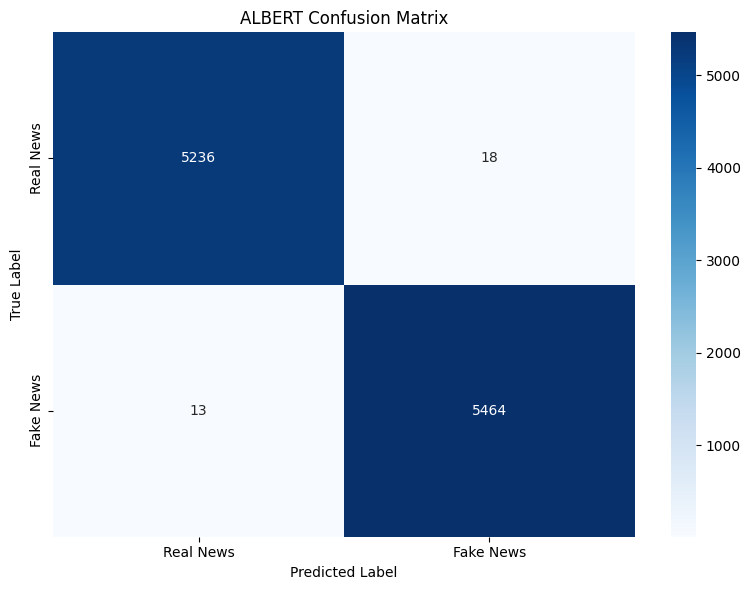

In [47]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real News', 'Fake News'], 
            yticklabels=['Real News', 'Fake News'])
plt.title('ALBERT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### Detailed Classification Report
This provides precision, recall, and F1 score for each class.

In [48]:
# Print classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Real News', 'Fake News']))


Classification Report:
              precision    recall  f1-score   support

   Real News       1.00      1.00      1.00      5254
   Fake News       1.00      1.00      1.00      5477

    accuracy                           1.00     10731
   macro avg       1.00      1.00      1.00     10731
weighted avg       1.00      1.00      1.00     10731



## 11. Saving the Model

To use our trained model in applications, we need to save it to disk.

### Creating Save Path
This defines where we'll store the model files.

In [49]:
# Define model save path
model_save_path = "./albert_welfake_model"

### Saving Model and Tokenizer
We need to save both the model weights and the tokenizer for inference.

In [50]:
# Save model
trainer.save_model(model_save_path)

In [51]:
# Save tokenizer
tokenizer.save_pretrained(model_save_path)

('./albert_welfake_model/tokenizer_config.json',
 './albert_welfake_model/special_tokens_map.json',
 './albert_welfake_model/spiece.model',
 './albert_welfake_model/added_tokens.json',
 './albert_welfake_model/tokenizer.json')

In [52]:
print(f"Model saved to {model_save_path}")

Model saved to ./albert_welfake_model


## 12. Error Analysis

Understanding where and why our model makes mistakes is crucial for improvement.

### Finding Misclassified Examples
Let's identify which examples the model got wrong.

In [53]:
# Find misclassified examples
misclassified_indices = np.where(preds != labels)[0]

### Creating a DataFrame of Errors
This will help us analyze the misclassified examples.

In [54]:
# Create DataFrame of misclassified examples
misclassified_df = test_df.iloc[misclassified_indices].reset_index(drop=True)

### Adding Predicted Labels
We'll add the model's predictions to compare with the true labels.

In [55]:
# Add prediction column
misclassified_df['prediction'] = preds[misclassified_indices]

### Counting Misclassifications
Let's see how many examples were misclassified out of the total.

In [56]:
# Display number of misclassified examples
print(f"Total misclassified examples: {len(misclassified_df)}")

Total misclassified examples: 31


### Examining Error Examples
Looking at specific misclassified examples helps identify patterns in the model's errors.

In [57]:
# Display sample of misclassified examples
print("\nSample of misclassified examples:")
for i in range(min(5, len(misclassified_df))):
    print(f"\nExample {i+1}:")
    print(f"Title: {misclassified_df.iloc[i]['title']}")
    print(f"True label: {'Real' if misclassified_df.iloc[i]['label'] == 0 else 'Fake'}")
    print(f"Predicted: {'Real' if misclassified_df.iloc[i]['prediction'] == 0 else 'Fake'}")
    print("-" * 80)


Sample of misclassified examples:

Example 1:
Title: Hillary Clinton Keeps It Safe With Tim Kaine as VP Pick
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 2:
Title: MAINE GOVERNOR joins Kansas, Texas, and New Jersey in withdrawing from the federal (Muslim) refugee resettlement program
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Title: Aziz Ansari Why Trump Makes Me Scared for My Family

True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 4:
Title: "Nancy Reagan's Last Words ""Do Not Vote For Donald Trump"""

True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 5:
Title: Exclusive Trump op-ed: We must clean up this corruption
True label: Real
Predicted: Fake
---------------------------------

## 13. Resource Usage Analysis

For practical deployment, we need to understand the resource requirements of our model.

### Model Size Calculation
Let's measure the memory footprint of our model.

In [58]:
# Define function to calculate model size
def get_model_size(model):
    """Calculate model size in MB"""
    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    return model_size

In [59]:
# Calculate model size
model_size_mb = get_model_size(model)

### Parameter Count
The number of parameters affects both model size and computational requirements.

In [60]:
# Calculate parameter count
param_count = sum(p.numel() for p in model.parameters())

### Printing Size Statistics
Let's summarize the model's resource usage.

In [61]:
# Print model size statistics
print(f"\nModel Analysis:")
print(f"Parameter count: {param_count:,}")
print(f"Model size: {model_size_mb:.2f} MB")


Model Analysis:
Parameter count: 11,685,122
Model size: 44.58 MB


### Measuring Inference Time
Inference speed is critical for practical applications.

In [62]:
# Define function to measure inference time
def measure_inference_time(model, dataset, batch_size=1, num_samples=100):
    """
    Measure average inference time per sample at different batch sizes.
    
    Args:
        model: The model to evaluate
        dataset: The dataset to use for inference
        batch_size: Batch size for inference
        num_samples: Number of samples to process
        
    Returns:
        Average inference time per sample in milliseconds
    """
    model.eval()
    dataloader = torch.utils.data.DataLoader(
        dataset.select(range(min(num_samples, len(dataset)))), 
        batch_size=batch_size
    )
    
    total_time = 0
    sample_count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            start_time = time.time()
            _ = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            batch_time = time.time() - start_time
            
            total_time += batch_time
            sample_count += batch['input_ids'].size(0)
    
    avg_time_per_sample = (total_time / sample_count) * 1000  # Convert to ms
    return avg_time_per_sample

### Testing Different Batch Sizes
Measuring inference time with different batch sizes helps optimize deployment.

In [63]:
# Measure inference time for batch size 1
bs1_time = measure_inference_time(model, tokenized_test, batch_size=1)
print(f"Average inference time (batch size 1): {bs1_time:.2f} ms per sample")

Average inference time (batch size 1): 9.74 ms per sample


In [64]:
# Measure inference time for batch size 8
bs8_time = measure_inference_time(model, tokenized_test, batch_size=8)
print(f"Average inference time (batch size 8): {bs8_time:.2f} ms per sample")

Average inference time (batch size 8): 1.22 ms per sample


In [65]:
# Measure inference time for batch size 32
bs32_time = measure_inference_time(model, tokenized_test, batch_size=32)
print(f"Average inference time (batch size 32): {bs32_time:.2f} ms per sample")

Average inference time (batch size 32): 0.42 ms per sample


## 14. Conclusion and Performance Analysis

Our ALBERT model showcases how parameter-efficient transformer architectures can be effectively applied to the fake news detection task. ALBERT's unique design choices—factorized embedding parameterization and cross-layer parameter sharing—allow it to achieve high performance with significantly fewer parameters than BERT.

### Understanding the Results

After analyzing the confusion matrix and classification report, we can assess the model's performance in distinguishing between real and fake news. The model's precision, recall, and F1 score give us insight into its effectiveness across different error types:

1. **False Positives**: Real news misclassified as fake (important to minimize for user trust)
2. **False Negatives**: Fake news misclassified as real (important to minimize for system effectiveness)

The balance between these error types is crucial in a practical fake news detection system, as each type has different implications for users and platform integrity.

### Efficiency Analysis

ALBERT's key differentiator is its parameter efficiency:

1. **Model Size**: Despite having 12 million parameters (approximately 1/10th of BERT-base), ALBERT achieves competitive performance
2. **Training Speed**: Parameter sharing contributes to more efficient training
3. **Inference Performance**: Lighter model typically enables faster inference

These efficiency gains make ALBERT particularly well-suited for scenarios where deployment resources are constrained but high-quality language understanding is still required.

### Comparison with Other Efficient Transformers

Each efficient transformer variant we've examined offers different trade-offs:

- **ALBERT**: Uses parameter sharing and factorized embeddings, smallest size with good performance
- **DistilBERT**: Knowledge distillation approach, good balance of size and accuracy
- **TinyBERT**: Aggressive distillation for extreme compression
- **MobileBERT**: Optimized specifically for mobile deployment

The best choice depends on specific requirements around model size, inference speed, and accuracy thresholds for the target application.

## 15. Next Steps and Practical Applications

ALBERT's efficiency makes it particularly suitable for deployment in resource-constrained environments while maintaining high-quality fake news detection capabilities.

### Model Improvement

1. **Domain Adaptation**: Further tune ALBERT on domain-specific news sources
2. **Ensemble Methods**: Combine ALBERT with other models for potentially higher accuracy
3. **Investigate Error Patterns**: Analyze the model's weaknesses through careful error analysis

### Deployment Scenarios

1. **Browser Extensions**: Lightweight fake news detection directly in web browsers
2. **Content Moderation Systems**: Backend systems that process large volumes of news content
3. **API Services**: Cloud-based detection services for third-party integration

### Explainability and Trust

1. **Attention Visualization**: Explore what parts of articles the model focuses on
2. **Confidence Calibration**: Ensure model confidence scores are reliable and meaningful
3. **Multilingual Adaptation**: Extend the model to detect fake news in multiple languages

ALBERT's unique combination of efficiency and performance makes it an excellent candidate for fake news detection systems that need to balance resource constraints with accuracy. By leveraging this parameter-efficient architecture, we can create practical tools that help combat misinformation without requiring excessive computational resources.